# Autotalker Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 29.01.2023
- **Date of Last Modification:** 12.03.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [3]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [55]:
## Dataset
dataset = "nanostring_cosmx_human_liver"
reference_batches = ["sample1"]
query_batches = ["sample2"]
n_neighbors = 12

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "cellType"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Benchmarking
spatial_knng_key = "autotalker_spatial_knng"
latent_knng_key = "autotalker_latent_knng"
mapping_entity_key = "mapping_entity"

## Others
random_seed = 42
load_timestamp = "10032023_145029"

### 1.3 Run Notebook Setup

In [6]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [7]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [8]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [11]:
# Define paths
figure_folder_path = f"../figures/{dataset}/analysis/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/analysis/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [56]:
adata_batch_list = []

for batch in reference_batches:
    adata = ad.read_h5ad(
        f"{srt_data_gold_folder_path}/{dataset}_{batch}.h5ad")
    adata.obs[mapping_entity_key] = "reference"
    adata_batch_list.append(adata)

for batch in query_batches:
    adata = ad.read_h5ad(
        f"{srt_data_gold_folder_path}/{dataset}_{batch}.h5ad")
    adata.obs[mapping_entity_key] = "query"
    adata_batch_list.append(adata)
        
for i in range(len(adata_batch_list)):
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch_list[i],
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch_list[i].obsp[adj_key] = (
        adata_batch_list[i].obsp[adj_key].maximum(
            adata_batch_list[i].obsp[adj_key].T))

### 2.2 Explore Data

Exploring reference dataset nanostring_cosmx_human_liver_sample1
Number of nodes (cells): 332877
Number of node features (genes): 1000


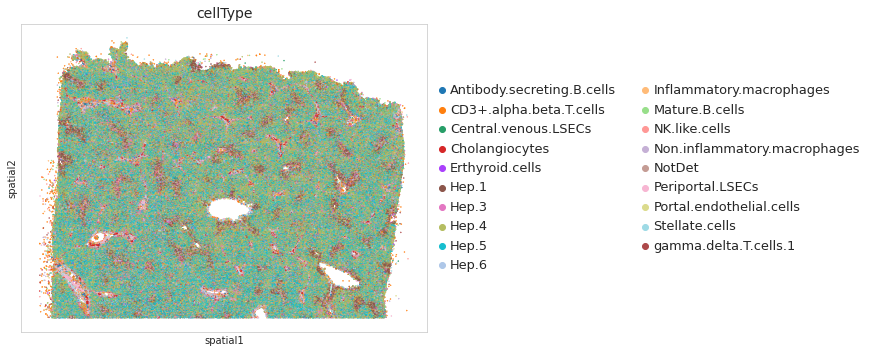

Exploring reference dataset nanostring_cosmx_human_liver_sample1
Number of nodes (cells): 460441
Number of node features (genes): 1000


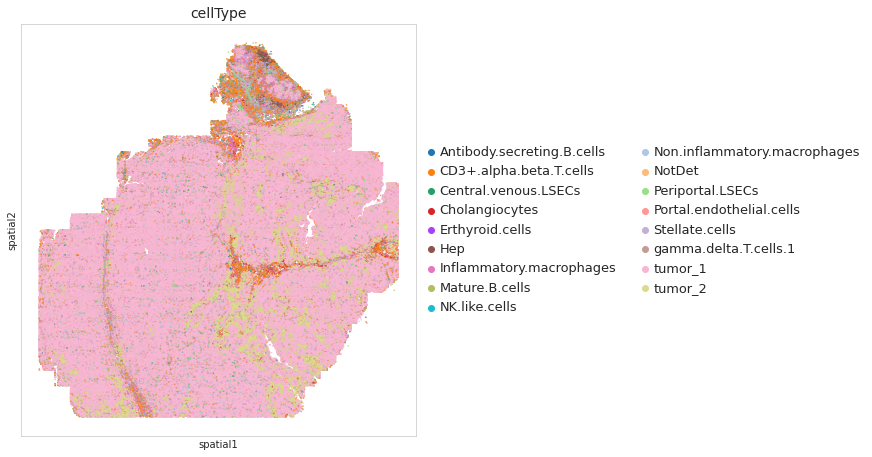

In [60]:
for i in range(len(adata_batch_list)):
    print(f"Exploring {adata_batch_list[0].obs[mapping_entity_key][0]} "
          f"dataset {dataset}_{adata_batch_list[0].obs[condition_key][0]}")     
    print("Number of nodes (cells): "
          f"{adata_batch_list[i].layers['counts'].shape[0]}")
    print("Number of node features (genes): "
          f"{adata_batch_list[i].layers['counts'].shape[1]}")
    # Visualize cell-level annotated data in physical space
    sq.pl.spatial_scatter(adata_batch_list[i],
                          color=cell_type_key,
                          shape=None,
                          figsize=(12, 12))
    plt.show()

Exploring reference dataset nanostring_cosmx_human_liver_sample1


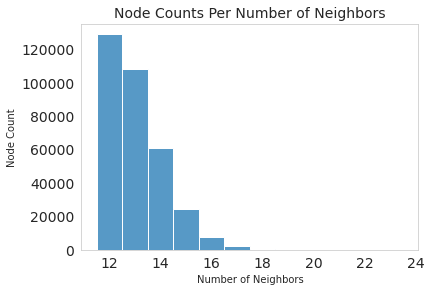

Average number of edges per node: 13.05.
Number of total edges: 2172443.

Exploring query dataset nanostring_cosmx_human_liver_sample2


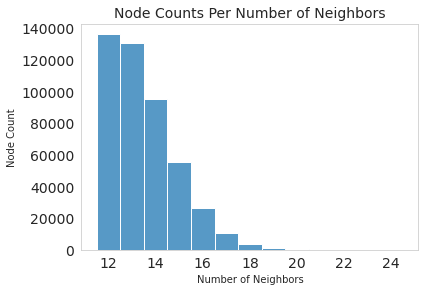

Average number of edges per node: 13.48.
Number of total edges: 3103269.



In [31]:
for i in range(len(adata_batch_list)):
    if i < len(reference_batches):
        entity = "reference"
        batch = reference_batches[i]
    else:
        entity = "query"
        batch = query_batches[i - len(reference_batches)]
    print(f"Exploring {entity} dataset {dataset}_{batch}")
    # Plot histogram of node counts per number of neighbors
    ax = sns.histplot(np.squeeze(np.asarray(
        adata_batch_list[i].obsp['spatial_connectivities'].sum(axis=0))),
                      discrete=True)
    ax.set_title("Node Counts Per Number of Neighbors")
    ax.set_ylabel("Node Count")
    ax.set_xlabel("Number of Neighbors")
    fig = ax.figure
    fig.savefig(f"{figure_folder_path}/node_counts_per_n_neighs_{batch}.png",
                bbox_inches="tight")
    plt.show()

    avg_edges_per_node = round(
        adata_batch_list[i].obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
    print(f"Average number of edges per node: {avg_edges_per_node}.")
    n_edges = int(sp.triu(
        adata_batch_list[i].obsp['spatial_connectivities'], k=1).sum())
    print(f"Number of total edges: {n_edges}.\n")

In [69]:
adata_reference_query = ad.concat(adata_batch_list, join="inner")

batch_connectivities = []
len_before_batch = 0

# Combine spatial neighborhood graphs as disconnected components
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
             (adata_reference_query.shape[0] -
              adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
             after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
             (adata_reference_query.shape[0] -
              adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
             adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
             (adata_reference_query.shape[0] -
              adata_batch_list[i].shape[0] -
              len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
             adata_batch_list[i].obsp[adj_key],
             after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
        
connectivities = sp.vstack(batch_connectivities)
adata_reference_query.obsp[adj_key] = connectivities

### 2.2 Prepare Data & GP Mask

#### 2.2.1 Filter Genes Based on GP Mask & HVG

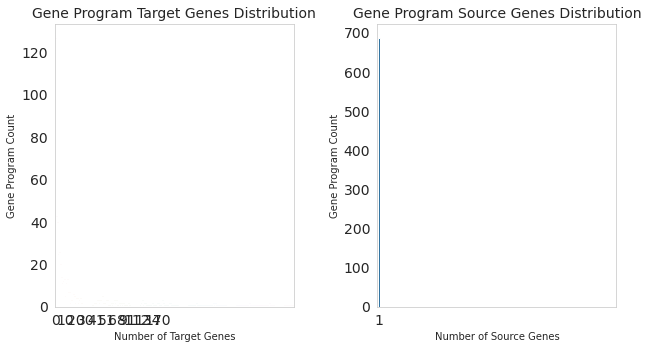

In [71]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=0.01,
    max_n_target_genes_per_gp=20000,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=True)

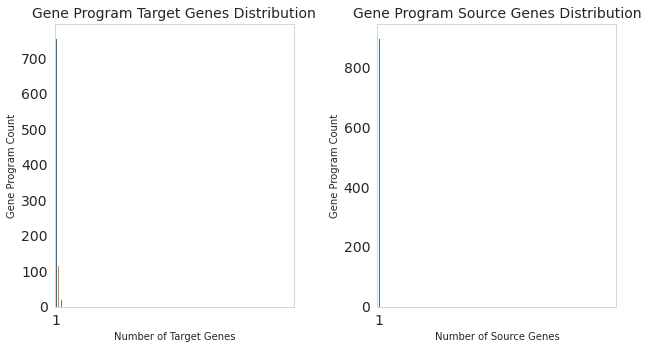

In [72]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=True)

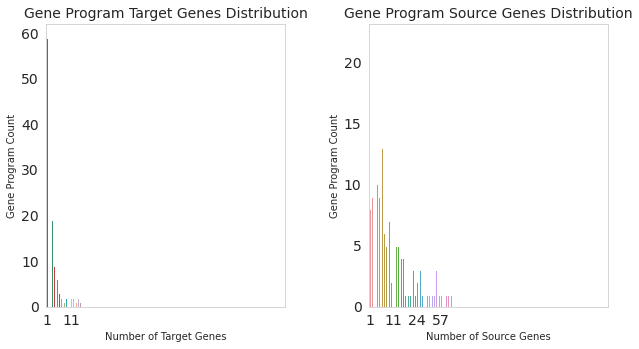

In [73]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True,
    plot_gp_gene_count_distributions=True)

In [74]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
#combined_gp_dict.update(mebocost_gp_dict)

In [75]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [76]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata_reference_query,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_reference_query.uns[gp_names_key])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_reference_query.uns[gp_names_key])}.")
print(f"Example gene programs: {random.sample(list(adata_reference_query.uns[gp_names_key]), 5)}.")
print(f"Number of gene program target genes: {adata_reference_query.varm[gp_targets_mask_key].sum()}.")
print(f"Number of gene program source genes: {adata_reference_query.varm[gp_sources_mask_key].sum()}.")

Number of gene programs with probed genes: 989.
Example gene programs: ['FGF16_ligand_targetgenes_GP', 'CXCL13_ligand_receptor_GP', 'HLA-DQB1_ligand_receptor_GP', 'EDIL3_ligand_receptor_GP', 'SORL1_ligand_receptor_GP'].
Number of gene program target genes: 24761.
Number of gene program source genes: 442.


## 4. Analysis

### 4.1 Load Model

In [77]:
if load_timestamp is not None:
    model_artifacts_folder_path = f"../artifacts/{dataset}/models/{load_timestamp}"

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/query",
                        adata=adata_reference_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 1000, n_cond_embed_input: 0, n_layers: 1, n_hidden: 989, n_latent: 989, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 180, n_output: 989, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 989, n_cond_embed_input: 180, n_addon_input: 0, n_output: 2000


In [78]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

Number of total gene programs: 989.
Number of active gene programs: 904.


In [79]:
# Store latent representation
model.adata.obsm[latent_key] = model.get_latent_representation(
    counts_key=counts_key,
    condition_key=condition_key)

In [ ]:
# Compute latent nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_knng_key)

# Use Autotalker latent space for UMAP generation
sc.tl.umap(model.adata,
           neighbors_key=latent_knng_key)

# Compute spatial nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=spatial_key,
                key_added=spatial_knng_key)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 size=320000/len(model.adata),
                 return_fig=True)
fig.set_size_inches(15, 10)
plt.title("Reference + Query: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with mapping entity annotations
fig = sc.pl.umap(model.adata,
                 color=[mapping_entity_key],
                 size=320000/len(model.adata),
                 return_fig=True)
fig.set_size_inches(15, 10)
plt.title("Reference + Query: Latent Space Mapping Entity Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight") 

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 size=320000/len(model.adata),
                 return_fig=True)
fig.set_size_inches(15, 10)
plt.title("Reference + Query: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")

In [53]:
model.adata.obs

AnnData object with n_obs × n_vars = 793318 × 1000
    obs: 'fov', 'cellType', 'niche', 'batch'
    uns: 'autotalker_source_genes_idx', 'autotalker_target_genes_idx', 'autotalker_genes_idx', 'autotalker_gp_names', 'autotalker_latent_knng', 'umap', 'autotalker_spatial_knng', 'batch_colors'
    obsm: 'spatial', 'autotalker_latent', 'X_umap'
    varm: 'autotalker_gp_sources', 'autotalker_gp_targets'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'autotalker_latent_knng_distances', 'autotalker_latent_knng_connectivities', 'autotalker_spatial_knng_distances', 'autotalker_spatial_knng_connectivities'

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key, key_added=latent_key)
sc.tl.umap(model.adata, neighbors_key=latent_key)

### 4.1 Cell Types in Spatial and Physical Space

In [ ]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
title = fig.suptitle(t="Cell Types in Physical and Latent Space",
                     x=0.85,
                     y=0.925,
                     fontsize=20)
sc.pl.spatial(adata=model.adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           size=640000/len(model.adata),
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.225, 0.625))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0, hspace=0.1)
fig.savefig(f"{figure_folder_path}/cell_types_physical_latent_space.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

#### 3.3.2 Mapping the Query

##### 3.3.2.1 Initialize, Train & Save Model

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/analysis/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load model trained on reference data for transfer learning with query data    
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/reference",
                        adata=adata_batch2,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=query_cond_embed_lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.3.2.2 Load & Save Model with Full Dataset & UMAP Features

In [ ]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/analysis/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/query",
                        adata=adata_reference_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

In [ ]:
# Store latent representation
model.adata.obsm[latent_key] = model.get_latent_representation(
    counts_key=counts_key,
    condition_key=condition_key)

In [ ]:
# Store active gene programs
model.adata.uns[active_gp_names_key] = model.get_active_gps()

In [ ]:
# Compute latent nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_knng_key)

# Use Autotalker latent space for UMAP generation
sc.tl.umap(model.adata,
           neighbors_key=latent_knng_key)

# Compute spatial nearest neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=spatial_key,
                key_added=spatial_knng_key)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
# Save adata
model.adata.write(f"{model_artifacts_folder_path}/{dataset}_integrated.h5ad")

##### 3.3.2.3 Visualize Latent Space

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference + Query: Latent Space Batch Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with mapping entity annotations
fig = sc.pl.umap(model.adata,
                 color=[mapping_entity_key],
                 legend_fontsize=12,
                 return_fig=True)
plt.title("Reference + Query: Latent Space Mapping Entity Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_mapping_entities_reference_query.png",
            bbox_inches="tight") 

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 return_fig=True)
plt.title("Reference + Query: Latent Space Cell Type Annotations", size=20, pad=15)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query.png",
            bbox_inches="tight")